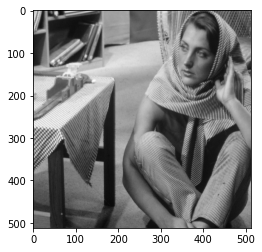

In [1]:
import os 
os.chdir(r"E:\ENMARTZ\SEMESTRE 10\Optimización Convexa\Proyecto\admm-matrix-completion")
# os.chdir(r"G:\Mi unidad\2021-I\optimizacion\admm-matrix-completion")

from data import load_gif_data
from core.utils import Mask
    
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)

DATA_DIR = "imgs/validation"
dataset = load_gif_data(DATA_DIR) / 255
img = dataset[0]

plt.imshow(img, cmap='gray')

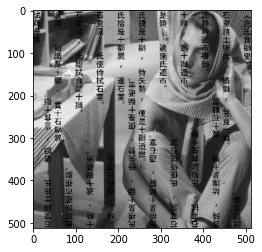

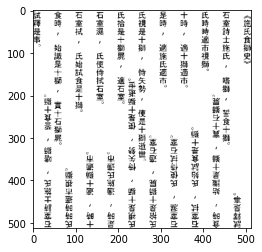

In [2]:
MODE = "text"
mask = Mask(mode=MODE, prcnt=0.5)

corrupted , mask = mask(img)
plt.imshow(corrupted, cmap='gray')
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

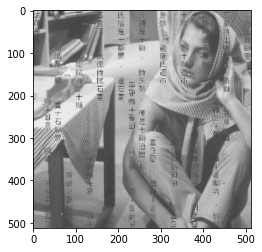

In [3]:
import bm3d

denoised = bm3d.bm3d(corrupted, sigma_psd=np.std(mask), stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
plt.imshow(denoised*(1-mask)+ corrupted, cmap='gray')

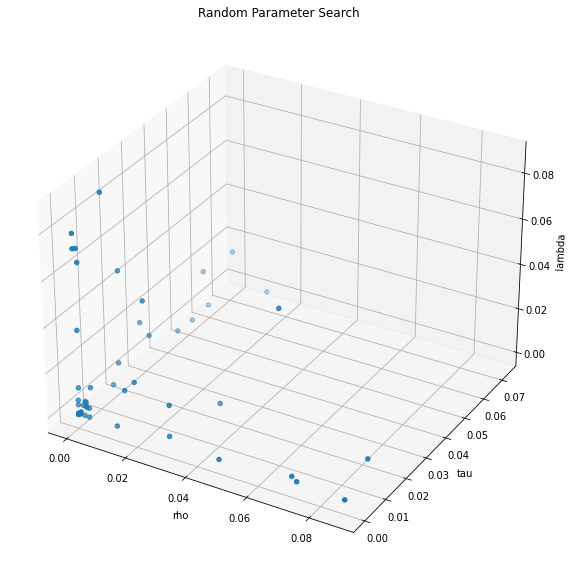

In [4]:
# Random parameter search. https://napsterinblue.github.io/notes/machine_learning/model_selection/random_search/

# log scale

min_exp, max_exp = -5, -1

np.random.seed(5)
rhos = 10 ** np.random.uniform(min_exp, max_exp, size=50)
taus = 10 ** np.random.uniform(min_exp, max_exp, size=50)
lams = 10 ** np.random.uniform(min_exp, max_exp, size=50)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(rhos, taus, lams)
ax.set_title('Random Parameter Search')
ax.set_xlabel('rho')
ax.set_ylabel('tau')
ax.set_zlabel('lambda')

fig.savefig("imgs/random_parameter_search.png", dpi=400)

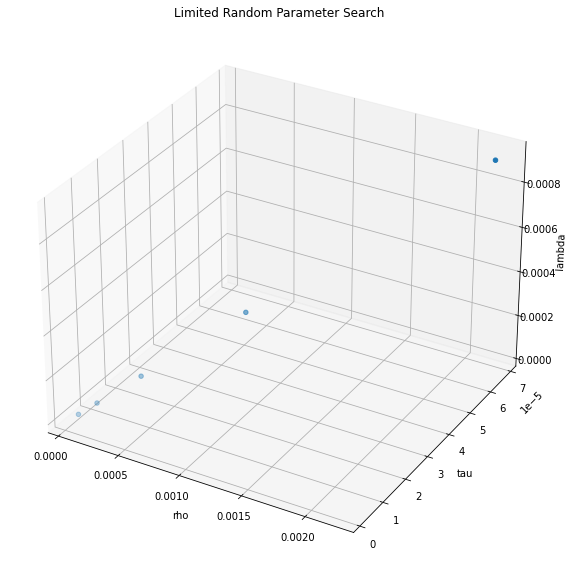

In [5]:
# best parameters
idx = 47

best_rho = rhos[idx]
best_tau = taus[idx]
best_lam = lams[idx]

# min_rho, max_rho = -0.25 + np.log10(best_rho), 0.25 + np.log10(best_rho)
# min_tau, max_tau = -0.25 + np.log10(best_tau), 0.25 + np.log10(best_tau)
# min_lam, max_lam = -0.25 + np.log10(best_lam), 0.25 + np.log10(best_lam)

min_rho, max_rho = -0.75 + np.log10(best_rho), 0.75 + np.log10(best_rho)
min_tau, max_tau = -0.75 + np.log10(best_tau), 0.75 + np.log10(best_tau)
min_lam, max_lam = -0.75 + np.log10(best_lam), 0.75 + np.log10(best_lam)

best_rhos = 10 ** np.linspace(min_rho, max_rho, num=5)
best_taus = 10 ** np.linspace(min_tau, max_tau, num=5)
best_lams = 10 ** np.linspace(min_lam, max_lam, num=5)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(best_rhos, best_taus, best_lams)
ax.set_title('Limited Random Parameter Search')
ax.set_xlabel('rho')
ax.set_ylabel('tau')
ax.set_zlabel('lambda')

fig.savefig("imgs/limited_random_parameter_search.png", dpi=400)

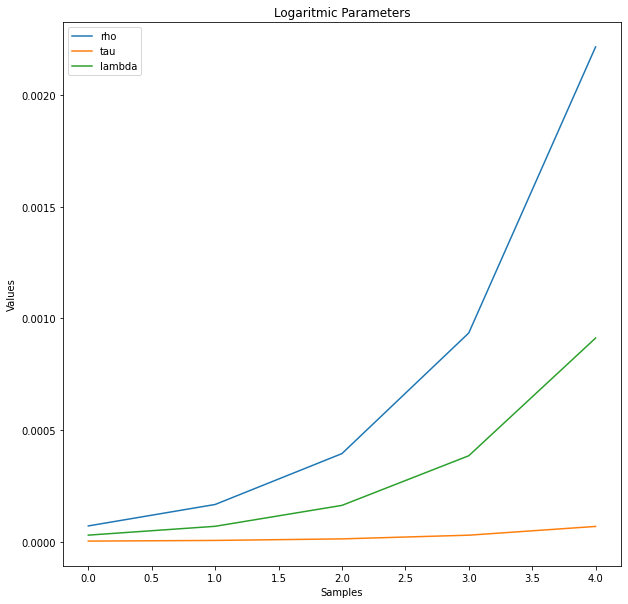

In [6]:
plt.figure(figsize=(10, 10))

plt.plot(best_rhos)
plt.plot(best_taus)
plt.plot(best_lams)
plt.title("Logaritmic Parameters")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend(["rho", "tau", "lambda"])

plt.savefig("imgs/log_parameters.png", dpi=400)

In [7]:
# get parameters for boxploting
from itertools import product

param_data = []
for i in range(3):
    for params in zip(best_rhos, best_taus, best_lams):
        aux_param = [best_rho, best_tau, best_lam]
        # print("xd", aux_param)
        aux_param[i] = params[i]
        # print("ws", aux_param)
        param_data.append(aux_param)

param_data


[[7.010987868219427e-05, 1.2066060923037498e-05, 0.0001622080674007667],
 [0.0001662567228140841, 1.2066060923037498e-05, 0.0001622080674007667],
 [0.0003942568208707973, 1.2066060923037498e-05, 0.0001622080674007667],
 [0.0009349302582907659, 1.2066060923037498e-05, 0.0001622080674007667],
 [0.002217069031138182, 1.2066060923037498e-05, 0.0001622080674007667],
 [0.0003942568208707973, 2.1456827699712822e-06, 0.0001622080674007667],
 [0.0003942568208707973, 5.088215701401165e-06, 0.0001622080674007667],
 [0.0003942568208707973, 1.2066060923037498e-05, 0.0001622080674007667],
 [0.0003942568208707973, 2.8613139603802726e-05, 0.0001622080674007667],
 [0.0003942568208707973, 6.785244689288395e-05, 0.0001622080674007667],
 [0.0003942568208707973, 1.2066060923037498e-05, 2.884512664009895e-05],
 [0.0003942568208707973, 1.2066060923037498e-05, 6.840257485081117e-05],
 [0.0003942568208707973, 1.2066060923037498e-05, 0.00016220806740076686],
 [0.0003942568208707973, 1.2066060923037498e-05, 0.00

Iteration [40 / 40] rho: 0.000394 tau: 1.2e-05 lambda: 0.000912: 100%|██████████| 40/40 [06:08<00:00,  9.20s/it, frob=13.2, psnr=31.8, ssim=0.86]

iteration 40 | error 13.24 | psnr 31.75 | ssim 0.86 | time 8.9373
Fin :3


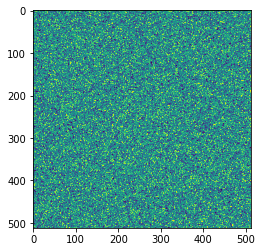

In [10]:
# from itertools import product
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
from core.admm_v2 import ADMM

iters = 40
# mask_names = ["text", "irregular", "random"]
mask_names = ["random"]

data = []
for k, mask_name in enumerate(mask_names):
    aux_data = param_data[k]
    for params in zip(param_data):

        best_r, best_t, best_l = params[0][0], params[0][1], params[0][2]

        history = []
        path = f'results_2/exp_{idx}_mask_{mask_name}_rho_{np.round(best_r, 6)}_tau_{np.round(best_t, 6)}_lambda_{np.round(best_l, 6)}.txt'

        for img in dataset:

            params = dict(rho=best_r,
                        tau=best_t,
                        lambd=best_l,
                        iters=iters
                        )

            mask = Mask(mode=mask_name, prcnt=0.5)
            corrupted, mask = mask(img)

            plt.imshow(mask)

            admm = ADMM()
            estimated, hist = admm.restore(corrupted, mask, sol=img, **params)
            history.append(hist)

        # save history
        
        frob_list = []
        psnr_list = []
        ssim_list = []
        with open(path, "w") as txt:
            txt.write("#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#\n")
            txt.write("      Model configuration and hyperparameters      \n")
            txt.write("#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#\n")
            txt.write(f"mask_{mask_name}\tbest_rho_{best_r}\tbest_tau_{best_t}\tbest_lambda_{best_l}\n")
            for his in history:
                # pos = np.argmax(his["psnr"])
                # frob, psnr, ssim = his["frob"][pos], his["psnr"][pos], his["ssim"][pos]
                frob, psnr, ssim = his["frob"][-1], his["psnr"][-1], his["ssim"][-1]
                txt.write(f'frob={frob}\tpsnr={psnr}\tssim={ssim}\n')
                frob_list.append(frob)
                psnr_list.append(psnr)
                ssim_list.append(ssim)
            txt.write('Promedio:\n')
            mean_frob, mean_psnr, mean_ssim = np.mean(frob_list), np.mean(psnr_list), np.mean(ssim_list)
            txt.write(f'frob={mean_frob}\tpsnr={mean_psnr}\tssim={mean_ssim}\n')

        # save history

        for i, his in enumerate(history):
            # np.save(f'history/image_{i + 1}_exp_{idx}_mask_{mask_name}_rho_{np.round(best_r, 6)}_best_t_{np.round(best_t, 6)}_lambda_{np.round(best_l, 6)}.npy', np.array([his["frob"], his["psnr"], his["ssim"]]))
            data.append([mask_name, best_r, best_t, best_l, i + 1, his["frob"][-1], his["psnr"][-1], his["ssim"][-1]])
        
        pd.DataFrame(data, columns=['mask', 'rho', 'tau', 'lambda', 'image', 'frob', 'psnr', 'ssim']).to_csv('history/data_' + mask_name + '.csv')

print('Fin :3')


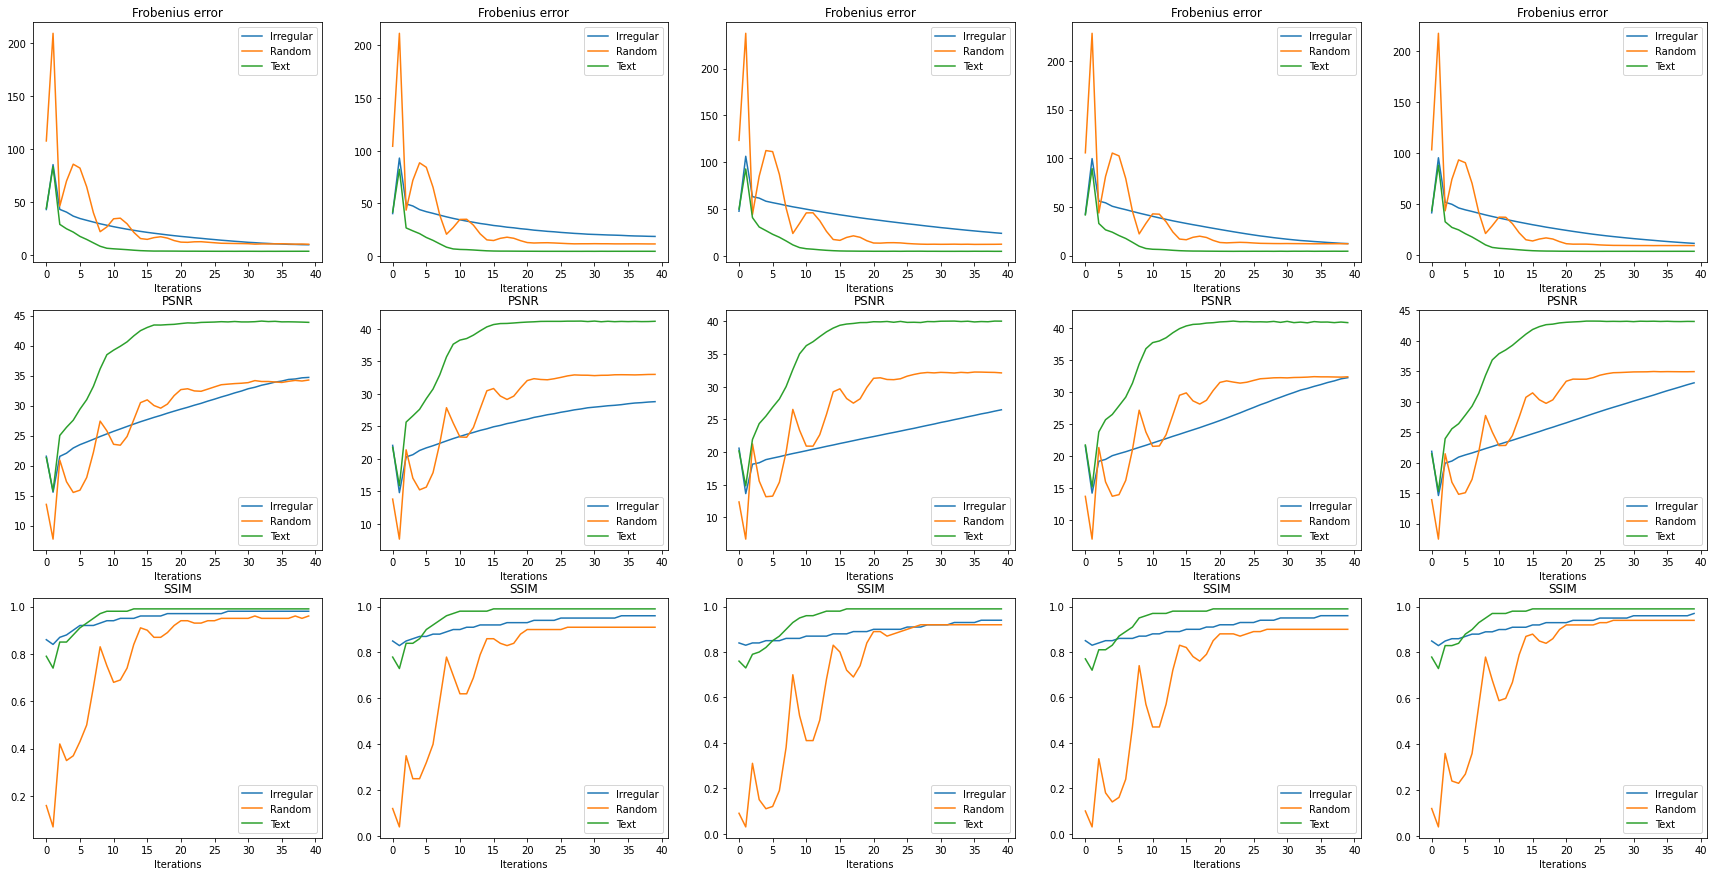

In [ ]:
# plot performance vs iterations (OBSOLETE)
fig, ax = plt.subplots(3, 5, figsize=(30, 15))

best_rho = rhos[idx]
best_tau = taus[idx]
best_lam = lams[idx]

for i in range(5):
    histor_ir = np.load(f'history/image_{i + 1}_exp_{idx}_mask_irregular_rho_{np.round(best_rho, 6)}_best_tau_{np.round(best_tau, 6)}_lambda_{np.round(best_lam, 6)}.npy')
    histor_ra = np.load(f'history/image_{i + 1}_exp_{idx}_mask_random_rho_{np.round(best_rho, 6)}_best_tau_{np.round(best_tau, 6)}_lambda_{np.round(best_lam, 6)}.npy')
    histor_te = np.load(f'history/image_{i + 1}_exp_{idx}_mask_text_rho_{np.round(best_rho, 6)}_best_tau_{np.round(best_tau, 6)}_lambda_{np.round(best_lam, 6)}.npy')

    ax[0, i].plot(np.vstack([histor_ir[0], histor_ra[0], histor_te[0]]).T)
    ax[0, i].set_title('Frobenius error')
    ax[0, i].set_xlabel('Iterations')
    ax[0, i].legend(['Irregular', 'Random', 'Text'])

    ax[1, i].plot(np.vstack([histor_ir[1], histor_ra[1], histor_te[1]]).T)
    ax[1, i].set_title('PSNR')
    ax[1, i].set_xlabel('Iterations')
    ax[1, i].legend(['Irregular', 'Random', 'Text'])

    ax[2, i].plot(np.vstack([histor_ir[2], histor_ra[2], histor_te[2]]).T)
    ax[2, i].set_title('SSIM')
    ax[2, i].set_xlabel('Iterations')
    ax[2, i].legend(['Irregular', 'Random', 'Text'])

plt.savefig("imgs/iterations", dpi=400)

In [63]:
text = pd.read_csv("history/data_text.csv")
irregular = pd.read_csv("history/data_irregular.csv")
random = pd.read_csv("history/data_random.csv")

In [98]:
from decimal import Decimal
def sci_notation(x):
    return f"{Decimal(x):.1e}"

text["rho"].apply(sci_notation)[:25]

0     7.0e-5
1     7.0e-5
2     7.0e-5
3     7.0e-5
4     7.0e-5
5     1.7e-4
6     1.7e-4
7     1.7e-4
8     1.7e-4
9     1.7e-4
10    3.9e-4
11    3.9e-4
12    3.9e-4
13    3.9e-4
14    3.9e-4
15    9.3e-4
16    9.3e-4
17    9.3e-4
18    9.3e-4
19    9.3e-4
20    2.2e-3
21    2.2e-3
22    2.2e-3
23    2.2e-3
24    2.2e-3
Name: rho, dtype: object

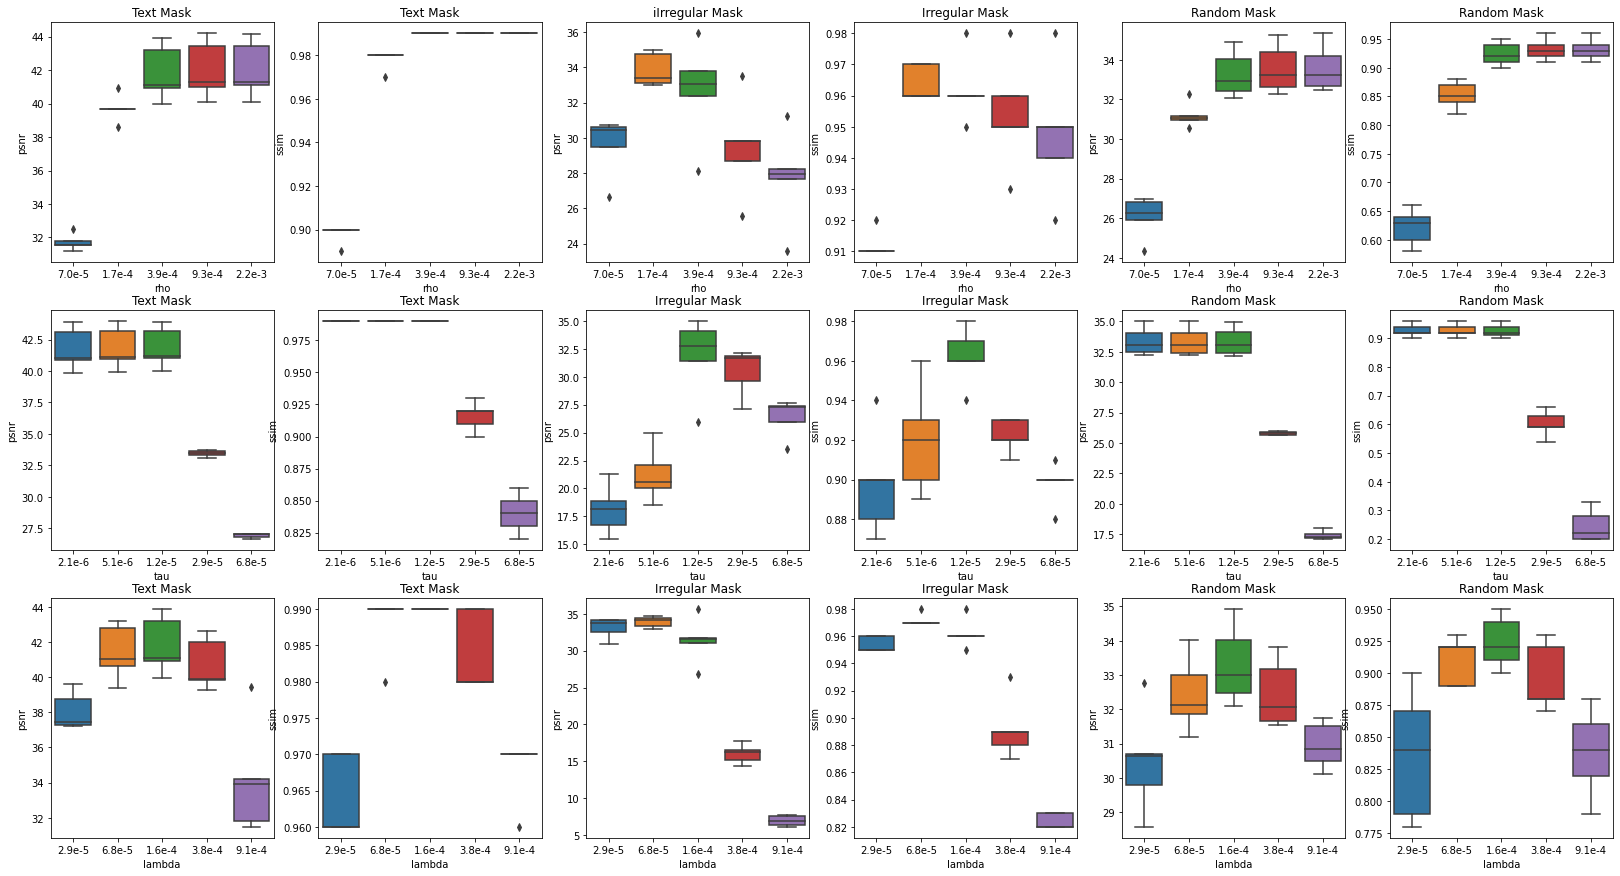

In [108]:
import seaborn as sns

fig, axes = plt.subplots(3, 6, figsize=(28, 15))
sns.boxplot(x=text["rho"].apply(sci_notation)[:25], y=text["psnr"][:25], orient='v', ax=axes[0, 0]).set_title("Text Mask")
sns.boxplot(x=text["tau"].apply(sci_notation)[25:50], y=text["psnr"][25:50], orient='v', ax=axes[1, 0]).set_title("Text Mask")
sns.boxplot(x=text["lambda"].apply(sci_notation)[-25:], y=text["psnr"][-25:], orient='v', ax=axes[2, 0]).set_title("Text Mask")
sns.boxplot(x=text["rho"].apply(sci_notation)[:25], y=text["ssim"][:25], orient='v', ax=axes[0, 1]).set_title("Text Mask")
sns.boxplot(x=text["tau"].apply(sci_notation)[25:50], y=text["ssim"][25:50], orient='v', ax=axes[1, 1]).set_title("Text Mask")
sns.boxplot(x=text["lambda"].apply(sci_notation)[-25:], y=text["ssim"][-25:], orient='v', ax=axes[2, 1]).set_title("Text Mask")

sns.boxplot(x=irregular["rho"].apply(sci_notation)[:25], y=irregular["psnr"][:25], orient='v', ax=axes[0, 2]).set_title("iIrregular Mask")
sns.boxplot(x=irregular["tau"].apply(sci_notation)[25:50], y=irregular["psnr"][25:50], orient='v', ax=axes[1, 2]).set_title("Irregular Mask")
sns.boxplot(x=irregular["lambda"].apply(sci_notation)[-25:], y=irregular["psnr"][-25:], orient='v', ax=axes[2, 2]).set_title("Irregular Mask")
sns.boxplot(x=irregular["rho"].apply(sci_notation)[:25], y=irregular["ssim"][:25], orient='v', ax=axes[0, 3]).set_title("Irregular Mask")
sns.boxplot(x=irregular["tau"].apply(sci_notation)[25:50], y=irregular["ssim"][25:50], orient='v', ax=axes[1, 3]).set_title("Irregular Mask")
sns.boxplot(x=irregular["lambda"].apply(sci_notation)[-25:], y=irregular["ssim"][-25:], orient='v', ax=axes[2, 3]).set_title("Irregular Mask")

sns.boxplot(x=random["rho"].apply(sci_notation)[:25], y=random["psnr"][:25], orient='v', ax=axes[0, 4]).set_title("Random Mask")
sns.boxplot(x=random["tau"].apply(sci_notation)[25:50], y=random["psnr"][25:50], orient='v', ax=axes[1, 4]).set_title("Random Mask")
sns.boxplot(x=random["lambda"].apply(sci_notation)[-25:], y=random["psnr"][-25:], orient='v', ax=axes[2, 4]).set_title("Random Mask")
sns.boxplot(x=random["rho"].apply(sci_notation)[:25], y=random["ssim"][:25], orient='v', ax=axes[0, 5]).set_title("Random Mask")
sns.boxplot(x=random["tau"].apply(sci_notation)[25:50], y=random["ssim"][25:50], orient='v', ax=axes[1, 5]).set_title("Random Mask")
sns.boxplot(x=random["lambda"].apply(sci_notation)[-25:], y=random["ssim"][-25:], orient='v', ax=axes[2, 5]).set_title("Random Mask")
plt.show()

fig.savefig("imgs/boxplots.png", dpi=400)
fig.savefig("imgs/boxplots.svg", dpi=400)

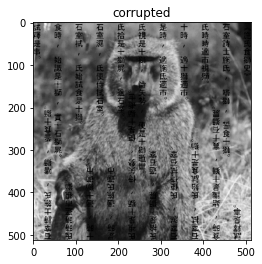

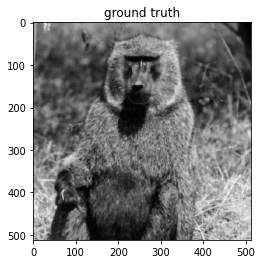

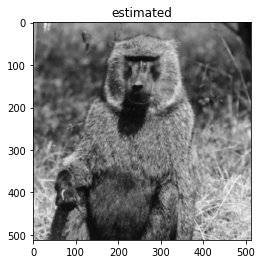

In [20]:
plt.title("corrupted")
plt.imshow(corrupted, cmap='gray')
plt.show()

plt.title("ground truth")
plt.imshow(img, cmap='gray')
plt.show()


plt.title("estimated")
plt.imshow(estimated, cmap='gray')
plt.show()

In [ ]:
# ! pip install bm3d
# ! pip install scikit-image
# ! pip install tqdm
# ! pip install seaborn